# 590-02 Final Project

## Roderick Whang (rjw34)

## 30-Day Readmission

A hospital readmission is an situation when a patient who had been discharged from a hospital is readmitted within a specified time interval. 
Readmission rates have increasingly been used as an outcome measure in health services research and as a quality benchmark for health systems. Higher readmission rate means ineffectiveness of treatment during the hospitalizations. Hospital readmission rates were formally included in reimbursement decisions for the Centers for Medicare and Medicaid Services (CMS) as part of the Patient Protection and Affordable Care Act (ACA) of 2010, which penalizes health systems with higher than expected readmission rates through the Hospital Readmission Reduction Program. Due to this penalty, there have been other programs that have been introduced, with the aim to decrease hospital readmission. The most common time frame is within 30-day of discharge, and this is what CMS uses.
To predict 30-day readmission, I use 3 datasets, ADIMISSIONS.csv, PATIENTS.csv, ICUSTAYS.csv from MIMIC-III Clinical Database Demo (https://physionet.org/content/mimiciii-demo/1.4/)

In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 1. Datasets

These are datasets for this project.

In [2]:
df1 = pd.read_csv('ADMISSIONS.csv')
df2 = pd.read_csv('PATIENTS.csv')
df3 = pd.read_csv('ICUSTAYS.csv')

In [3]:
# ADIMISSIONS
df1.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
# PATIENTS
df2.head(5)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [5]:
# ICUSTAYS
df3.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [6]:
df1.shape

(58976, 19)

In [7]:
df2.shape

(46520, 8)

In [8]:
df3.shape

(61532, 12)

Merge ADMISSIONS, PATIENTS and ICUSTAYS datasets upon SUBJECT_ID

In [9]:
df4 = pd.merge(df1,df2,on='SUBJECT_ID')

In [10]:
df = pd.merge(df4,df3,on='SUBJECT_ID')

## 2. Exploratory Data Analysis

In [11]:
df.shape

(116426, 37)

In [12]:
df.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID_x,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HADM_ID_y,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,165315,204798,carevue,MICU,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,152223,227807,carevue,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641
2,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,124321,234044,metavision,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862
3,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,152223,227807,carevue,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641
4,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,124321,234044,metavision,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862


In [13]:
print('Number of unique patient ids: {}'.format(len(df.SUBJECT_ID.unique())))

Number of unique patient ids: 46476


Text(0, 0.5, '')

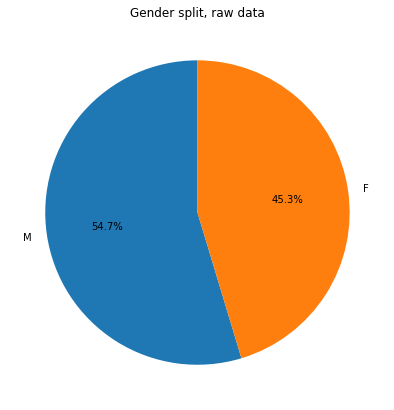

In [14]:
fig = plt.figure(figsize=(7,7))
df.GENDER.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')


Text(0, 0.5, '')

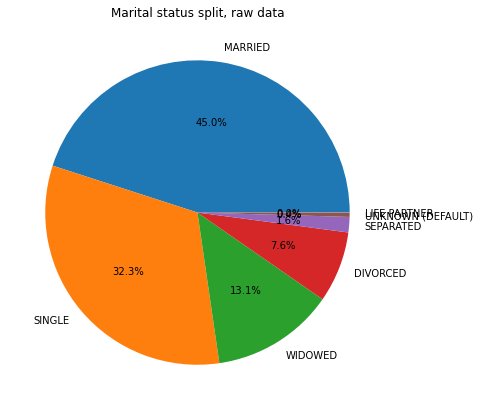

In [15]:
fig = plt.figure(figsize=(7,7))
df.MARITAL_STATUS.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')

Text(0, 0.5, '')

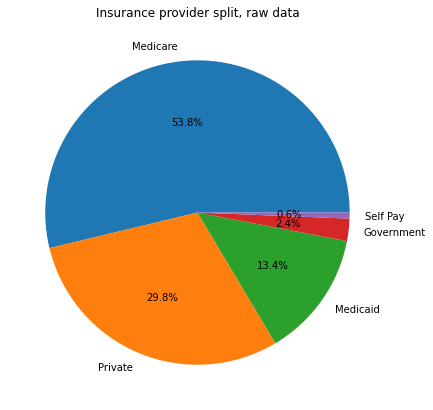

In [16]:
fig = plt.figure(figsize=(7,7))
df.INSURANCE.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')

Text(0, 0.5, '')

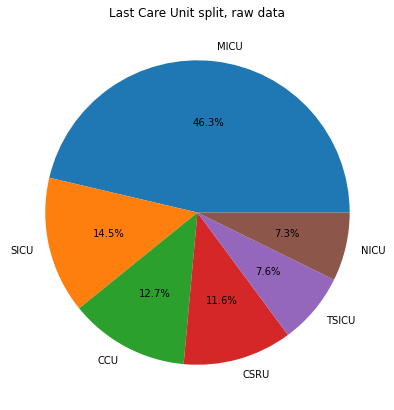

In [17]:
fig = plt.figure(figsize=(7,7))
df.LAST_CAREUNIT.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Last Care Unit split, raw data')
plt.ylabel('')

In [18]:
df.LAST_CAREUNIT.value_counts()

MICU     53935
SICU     16891
CCU      14804
CSRU     13491
TSICU     8833
NICU      8472
Name: LAST_CAREUNIT, dtype: int64

## 3. Preprocessing

### 3-1. Extract readmission time information

In [19]:
df['DISCHTIME'] = df['DISCHTIME'].astype('datetime64[ns]')
df['ADMITTIME'] = df['ADMITTIME'].astype('datetime64[ns]')

In [20]:
# calculate time delta between subsequent readmissions of the same patient 
df['readmit_dt'] = np.zeros(df.shape[0])
df['next_readmit_dt'] = np.zeros(df.shape[0])

In [21]:
for idx in np.arange(1,df.shape[0]):
    if df.SUBJECT_ID[idx] == df.SUBJECT_ID[idx - 1]:     
        prev_disch = df.DISCHTIME[idx-1]
        curr_adm = df.ADMITTIME[idx]
        dt = curr_adm - prev_disch
        dt_hrs_calc = np.round(dt.value/3600.0/1e9,2)

        df.at[idx, 'readmit_dt'] = dt_hrs_calc
        df.at[idx-1, 'next_readmit_dt'] = dt_hrs_calc

#### Define time threshold and corresponding labels

In [22]:
# Define threshold in hours
threshold = 30*24
df['future_readmit'] = None
df['future_readmit'] = ['No' if dt == 0.0 else 'Yes' if dt>=threshold else 'No' for dt in df.next_readmit_dt]

In [23]:
df.iloc[:,-3:].head()

,readmit_dt,next_readmit_dt,future_readmit
0,0.00,0.00,No
1,0.00,-131.92,No
2,-131.92,36024.40,Yes
3,36024.40,-162.43,No
4,-162.43,0.00,No


In [24]:
print('Value counts:')
print(df.future_readmit.value_counts())
 
print ('\nValue proportions:')
print(df.future_readmit.value_counts()/df.shape[0])

Value counts:
No     107436
Yes      8990
Name: future_readmit, dtype: int64

Value proportions:
No     0.922784
Yes    0.077216
Name: future_readmit, dtype: float64


In [25]:
df.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID_x', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'ROW_ID_y', 'GENDER',
       'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ROW_ID',
       'HADM_ID_y', 'ICUSTAY_ID', 'DBSOURCE', 'FIRST_CAREUNIT',
       'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME',
       'LOS', 'readmit_dt', 'next_readmit_dt', 'future_readmit'],
      dtype='object')

In [26]:
df = df.drop(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID_x', 'ADMITTIME', 'DISCHTIME','DEATHTIME', 'EDREGTIME',\
              'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', \
              'ROW_ID_y','DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG',\
              'ROW_ID','HADM_ID_y', 'ICUSTAY_ID', 'DBSOURCE', 'FIRST_WARDID', \
              'LAST_WARDID', 'INTIME', 'OUTTIME','LOS','readmit_dt','next_readmit_dt'], axis = 1) 

### 3-2. Check and Clean up missing or invalid values

In [27]:
np.sum(df.isnull())

ADMISSION_TYPE            0
ADMISSION_LOCATION        0
DISCHARGE_LOCATION        0
INSURANCE                 0
LANGUAGE              39787
RELIGION                525
MARITAL_STATUS        10929
ETHNICITY                 0
DIAGNOSIS                55
GENDER                    0
FIRST_CAREUNIT            0
LAST_CAREUNIT             0
future_readmit            0
dtype: int64

In [28]:
is_NaN = df. isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN)

       ADMISSION_TYPE         ADMISSION_LOCATION         DISCHARGE_LOCATION  \
0           EMERGENCY       EMERGENCY ROOM ADMIT  DISC-TRAN CANCER/CHLDRN H   
1            ELECTIVE  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE   
2            ELECTIVE  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE   
5           EMERGENCY  TRANSFER FROM HOSP/EXTRAM                       HOME   
6           EMERGENCY       EMERGENCY ROOM ADMIT                       HOME   
...               ...                        ...                        ...   
116180      EMERGENCY  CLINIC REFERRAL/PREMATURE                       HOME   
116216      EMERGENCY  TRANSFER FROM HOSP/EXTRAM                        SNF   
116301      EMERGENCY  CLINIC REFERRAL/PREMATURE               DEAD/EXPIRED   
116302      EMERGENCY  CLINIC REFERRAL/PREMATURE               DEAD/EXPIRED   
116333      EMERGENCY  CLINIC REFERRAL/PREMATURE               DEAD/EXPIRED   

       INSURANCE LANGUAGE           RELIGION MARITA

In [29]:
# remove null
df = df.dropna()

In [30]:
np.sum(df.isnull())

ADMISSION_TYPE        0
ADMISSION_LOCATION    0
DISCHARGE_LOCATION    0
INSURANCE             0
LANGUAGE              0
RELIGION              0
MARITAL_STATUS        0
ETHNICITY             0
DIAGNOSIS             0
GENDER                0
FIRST_CAREUNIT        0
LAST_CAREUNIT         0
future_readmit        0
dtype: int64

### 3-3. Labeling categorical values

In [31]:
df = df.astype('category')

In [32]:
labelencoder = LabelEncoder()

In [33]:
for col in df.columns:
    df[col+'_cat'] = labelencoder.fit_transform(df[col])

In [34]:
df.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,...,INSURANCE_cat,LANGUAGE_cat,RELIGION_cat,MARITAL_STATUS_cat,ETHNICITY_cat,DIAGNOSIS_cat,GENDER_cat,FIRST_CAREUNIT_cat,LAST_CAREUNIT_cat,future_readmit_cat
3,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,...,2,48,3,2,36,1674,1,1,1,0
4,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,...,2,48,3,2,36,1674,1,4,4,0
14,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,CHEST PAIN\CATH,M,...,2,48,3,2,36,2262,1,2,2,0
15,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,CHEST PAIN\CATH,M,...,2,48,3,2,36,2262,1,0,0,1
16,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRADYCARDIA,M,...,2,48,3,2,36,1637,1,2,2,0


In [35]:
df.keys()

Index(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'DIAGNOSIS', 'GENDER', 'FIRST_CAREUNIT', 'LAST_CAREUNIT',
       'future_readmit', 'ADMISSION_TYPE_cat', 'ADMISSION_LOCATION_cat',
       'DISCHARGE_LOCATION_cat', 'INSURANCE_cat', 'LANGUAGE_cat',
       'RELIGION_cat', 'MARITAL_STATUS_cat', 'ETHNICITY_cat', 'DIAGNOSIS_cat',
       'GENDER_cat', 'FIRST_CAREUNIT_cat', 'LAST_CAREUNIT_cat',
       'future_readmit_cat'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75188 entries, 3 to 116425
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ADMISSION_TYPE          75188 non-null  category
 1   ADMISSION_LOCATION      75188 non-null  category
 2   DISCHARGE_LOCATION      75188 non-null  category
 3   INSURANCE               75188 non-null  category
 4   LANGUAGE                75188 non-null  category
 5   RELIGION                75188 non-null  category
 6   MARITAL_STATUS          75188 non-null  category
 7   ETHNICITY               75188 non-null  category
 8   DIAGNOSIS               75188 non-null  category
 9   GENDER                  75188 non-null  category
 10  FIRST_CAREUNIT          75188 non-null  category
 11  LAST_CAREUNIT           75188 non-null  category
 12  future_readmit          75188 non-null  category
 13  ADMISSION_TYPE_cat      75188 non-null  int32   
 14  ADMISSION_LOCATION_ca

In [37]:
df_new = df.drop(['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'DIAGNOSIS', 'GENDER', 'FIRST_CAREUNIT', 'LAST_CAREUNIT',
       'future_readmit'], axis = 1)

In [38]:
df_new.head()

,ADMISSION_TYPE_cat,ADMISSION_LOCATION_cat,DISCHARGE_LOCATION_cat,INSURANCE_cat,LANGUAGE_cat,RELIGION_cat,MARITAL_STATUS_cat,ETHNICITY_cat,DIAGNOSIS_cat,GENDER_cat,FIRST_CAREUNIT_cat,LAST_CAREUNIT_cat,future_readmit_cat
3,1,5,5,2,48,3,2,36,1674,1,1,1,0
4,1,5,5,2,48,3,2,36,1674,1,4,4,0
14,1,5,4,2,48,3,2,36,2262,1,2,2,0
15,1,5,4,2,48,3,2,36,2262,1,0,0,1
16,1,1,5,2,48,3,2,36,1637,1,2,2,0


In [39]:
print('Value counts:')
print(df_new.future_readmit_cat.value_counts())

Value counts:
0    69104
1     6084
Name: future_readmit_cat, dtype: int64


#### This is an imbalanced dataset. Perform upsampling for minor sample (Label = 1)

In [40]:
from sklearn.utils import resample
df_major = df_new[df_new.future_readmit_cat == 0]
df_minor = df_new[df_new.future_readmit_cat == 1]

df_minor_upsample  = resample(df_minor, replace = True, \
                              n_samples=69104, random_state = 123)
df_up = pd.concat([df_minor_upsample, df_major])

In [41]:
print('Value counts:')
print(df_up.future_readmit_cat.value_counts())

Value counts:
1    69104
0    69104
Name: future_readmit_cat, dtype: int64


### 3-4. Correlation Matrix

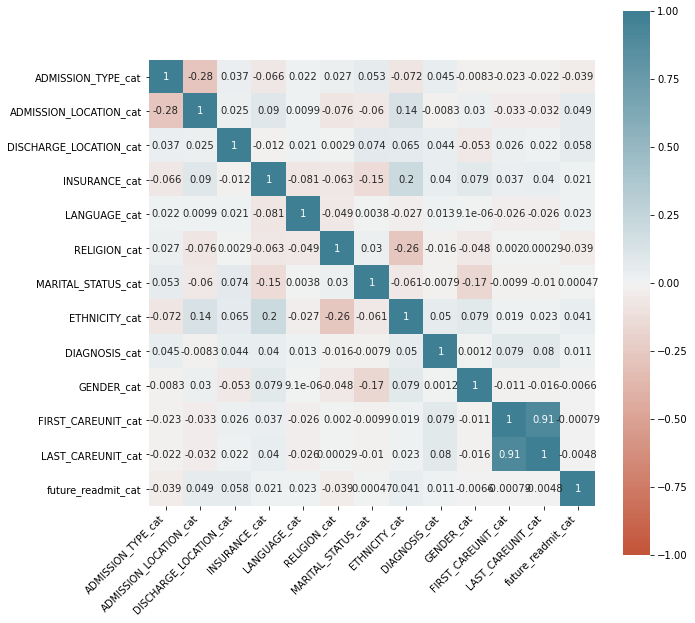

In [42]:
corr = df_up.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), annot=True,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



FIRST_CAREUNIT and LAST_CAREUNIT are highly correlated and will remove FIRST_CAREUNIT feature

In [43]:
X = df_up.iloc[:,0:12]
y = df_up.iloc[:,-1]

In [44]:
# remove FIRST_CAREUNIT_cat feature
X = X.drop(['FIRST_CAREUNIT_cat'], axis =1)

In [45]:
# splittin dataset into train and test sets
x_tr, x_test, y_tr, y_test = train_test_split(X, y)

## 4. Models

### 4-1. Logistic Regression

As a baseline model, I trained Logsitic regression model.

In [46]:
lr = LogisticRegression(penalty='l2', C=1)
# Fit the model
lr.fit(x_tr, y_tr)

# probabilities for the target
lr_pred_prob = lr.predict_proba(x_test)
# prediction
lr_pred = lr.predict(x_test)

#### Cross Validations

In [47]:
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=5)
print('Cross-Validation Accuracy Scores', scores)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-Validation Accuracy Scores [0.55603791 0.51063599 0.50350915 0.51199305 0.50522774]


In [48]:
scores = pd.Series(scores)
print("min accuracy: ", scores.min())
print("mean accuracy: ", scores.mean())
print("max accuracy: ", scores.max())

min accuracy:  0.5035091527385862
mean accuracy:  0.5174807699934535
max accuracy:  0.5560379133203097


#### Accuracy score

In [49]:
# accuracy score
accuracy_score(y_test, lr_pred)

0.5347881454040287

#### Confusion Matrix

In [50]:
# confusion matrix
confusion = confusion_matrix(y_test, lr_pred)
confusion

array([[9119, 8270],
       [7804, 9359]], dtype=int64)

#### Classification Report

In [51]:
#Classification Report
print(classification_report(y_test, lr_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.54      0.52      0.53     17389
           1       0.53      0.55      0.54     17163

    accuracy                           0.53     34552
   macro avg       0.53      0.53      0.53     34552
weighted avg       0.53      0.53      0.53     34552



In [52]:
# calculation for ROC/PR curve => plots are below
l_fpr, l_tpr, _ = roc_curve(y_test, lr_pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [53]:
l_precision, l_recall, _ = precision_recall_curve(y_test, lr_pred_prob[:,1])

In [54]:
AUC = roc_auc_score(y_test, lr_pred_prob[:, 1])
AUC

0.5512224001329655

### 4-2 Random Forest

In [55]:
forest = RandomForestClassifier()

In [56]:
#exhaustive grid search is a good way to determine the best hyperparameter values to use

n_estimators = [20,25,30, 35]
max_depth = [15, 25, 30]
min_samples_split = [20,30,50,100]
min_samples_leaf = [2,5, 10, 15] 

hyperPar = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

In [57]:
# k=5-fold
rf_grid = GridSearchCV(forest, hyperPar, cv = 5, verbose = 1, n_jobs = -1)

In [58]:
rf_best = rf_grid.fit(x_tr, y_tr)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 14.0min finished


In [59]:
# find optimal hyper-parameters
rf_best.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 35}

In [60]:
# fitting with optimal hyperparameters
rf_opt = RandomForestClassifier(random_state = 1, max_depth = 30,\
                                   n_estimators = 35, min_samples_split = 20, min_samples_leaf = 2)
rf_opt.fit(x_tr, y_tr)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=35, random_state=1)

In [61]:
# prediction
rf_pred = rf_opt.predict(x_test)

In [62]:
# probabilities for the target
rf_pred_prob = rf_opt.predict_proba(x_test)

#### Crosss Validation

In [63]:
scores_r = cross_val_score(rf_opt, x_tr, y_tr, scoring='accuracy', cv=5)
print('Cross-Validation Accuracy Scores', scores_r)

Cross-Validation Accuracy Scores [0.82355779 0.82239159 0.8230669  0.81862911 0.82634702]


In [64]:
rfscores = pd.Series(scores_r)
print("min accuracy: ", rfscores.min())
print("mean accuracy: ", rfscores.mean())
print("max accuracy: ", rfscores.max())

min accuracy:  0.8186291061695046
mean accuracy:  0.8227984799789198
max accuracy:  0.8263470165452703


#### Accuracy score

In [65]:
# accuracy score
accuracy_score(y_test, rf_pred)

0.8437717064135216

#### Confusion Matrix

In [66]:
# confusion matrix
confusion = confusion_matrix(y_test, rf_pred)
confusion

array([[13447,  3942],
       [ 1456, 15707]], dtype=int64)

#### Classification Report

In [67]:
print(classification_report(y_test, rf_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     17389
           1       0.80      0.92      0.85     17163

    accuracy                           0.84     34552
   macro avg       0.85      0.84      0.84     34552
weighted avg       0.85      0.84      0.84     34552



#### Variable Importance

Text(0.5, 1.0, 'Feature Importance')

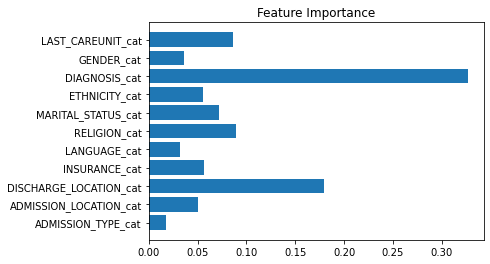

In [68]:
import matplotlib.pyplot as plt
plt.barh(x_tr.columns, rf_opt.feature_importances_)
plt.title('Feature Importance')

DIAGNOSIS feature is most important for the accuracy of model ad DISCHARGE_LOCATION is also important.

In [69]:
# RF ROC AUC calculation
AUC = roc_auc_score(y_test, rf_pred_prob[:, 1])
AUC

0.910673971779557

### 4-3. Model Comparison Logistic Regression vs Random Forest

### ROC curve (receiver operating characteristic curve)

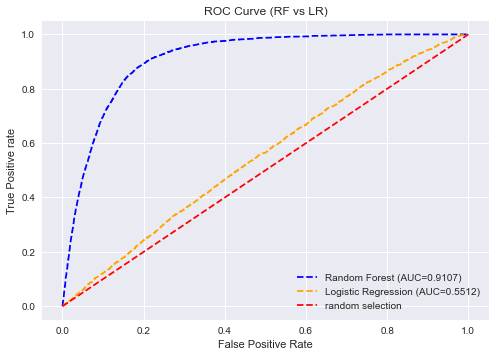

In [70]:
fpr, tpr, _ = roc_curve(y_test, rf_pred_prob[:,1], pos_label=1)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='blue', label=f'Random Forest (AUC={auc(fpr, tpr):.4f})')
plt.plot(l_fpr, l_tpr, linestyle='--',color='orange', label=f'Logistic Regression (AUC={auc(l_fpr, l_tpr):.4f})')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red', label = 'random selection')
plt.title('ROC Curve (RF vs LR)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();


### PR Curve (Precision-Recall curves)

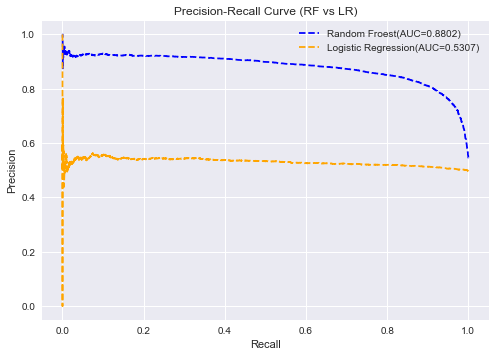

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_pred_prob[:,1])
# plot pr curves
plt.plot(recall, precision, linestyle='--',color='blue', label=f'Random Froest(AUC={auc(recall, precision):.4f})')
plt.plot(l_recall, l_precision, linestyle='--',color='orange', label=f'Logistic Regression(AUC={auc(l_recall, l_precision):.4f})')
plt.title('Precision-Recall Curve (RF vs LR)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show();

## 5. Conclusion

In this project, I tried to predict 30-day readmission with two machine learning models, Logistic Regression and Random Forest.
From the evaluation metrics that accuracy, recall, precision, ROC curve, PR curve, etc., I could see that overall performance of Random Forest outperforms Logistic Regression model. Dataset which is used in this project consists of mostly categorical features. I could see that Random Forest works better when dataset consists of categorical features and Logistic Regression model works poorly in this case.
As future works, we can use or combine other datasets to imporve the performance and try deep-learning model.

### References

1. https://www.cms.gov/medicare/medicare-fee-for-service-payment/acuteinpatientpps/readmissions-reduction-program
2. https://www.kff.org/medicare/issue-brief/aiming-for-fewer-hospital-u-turns-the-medicare-hospital-readmission-reduction-program/
